# Local and Central DP with Fed-BioMed: MONAI 2d image registration

## Introduction

This tutorial shows how to deploy in Fed-BioMed the 2d image registration example provided in the project MONAI (https://monai.io/), trained with Differential Privacy (DP). We are going to compare results of:
* non private training
* train with Local Differential Privacy (LDP)
* train with Central Differential Privacy (CDP)

In order to enforce differential privacy during training (both local and central) we will rely on the Opcaus library (https://opacus.ai/). 

## Image Registration

Image registration is the process of transforming and recalibrating different images into one coordinate system. It makes possible to compare several images captured with the same modality.

In this tutorial, we are using a UNet-like registration network ( https://arxiv.org/abs/1711.01666 ).
Goal of the notebook is to train a model given moving images and fixed images (recalibrated images). 

## Start the network
Before running this notebook, start the network with `./scripts/fedbiomed_run network`

## Creating MedNIST nodes

MedNIST provides an artificial 2d classification dataset created by gathering different medical imaging datasets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

To proceed with the tutorial, we created an iid partitioning of the MedNIST dataset between 3 clients. Each client has 3000 image samples for each class. The training partitions are availables at the following link:

https://drive.google.com/file/d/1vLIcBdtdAhh6K-vrgCFy_0Y55dxOWZwf/view

The dataset owned by each client has structure:


└── client_*/

    ├── AbdomenCT/
    
    └── BreastMRI/
    
    └── CXR/
    
    └── ChestCT/
    
    └── Hand/
    
    └── HeadCT/   

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 
After activating the fedbiomed network with the commands

`source ./scripts/fedbiomed_environment network`

and 

`./scripts/fedbiomed_run network`

we create a first node by using the commands

`source ./scripts/fedbiomed_environment node`

`./scripts/fedbiomed_run node start`

We then poulate the node with the data of first client:

`./scripts/fedbiomed_run node add`

We select option 3 (images) to add MedNIST partition of client 1, by just picking the folder of client 1. 
Assign tag `mednist` to the data when asked.

We can further check that the data has been added by executing `./scripts/fedbiomed_run node list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively.


## Running Fed-BioMed Researcher

We are now ready to start the reseracher enviroment with the command `source ./scripts/fedbiomed_environment researcher`, and open the Jupyter notebook. 

We can first quesry the network for the mednist dataset. In this case, the nodes are sharing the respective partitions unsing the same tag `mednist`:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-05-30 12:18:44,814 fedbiomed INFO - Component environment:
2022-05-30 12:18:44,816 fedbiomed INFO - type = ComponentType.RESEARCHER
2022-05-30 12:18:45,114 fedbiomed INFO - Messaging researcher_34b8c449-5772-465a-a4ab-1e3614a0470b successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x13a534850>
2022-05-30 12:18:45,159 fedbiomed INFO - Listing available datasets in all nodes... 
2022-05-30 12:18:55,167 fedbiomed INFO - 
 Node: node_38eef0c1-818d-46d9-a702-4c119a6bddbd | Number of Datasets: 1 
+---------+-------------+--------------------------+-----------------+--------------------+
| name    | data_type   | tags                     | description     | shape              |
+=========+=============+==========================+=================+====================+
| MEDNIST | mednist     | ['#MEDNIST', '#dataset'] | MEDNIST dataset | [58954, 3, 64, 64] |
+---------+-------------+--------------------------+-----------------+---------

{'node_38eef0c1-818d-46d9-a702-4c119a6bddbd': [{'name': 'MEDNIST',
   'data_type': 'mednist',
   'tags': ['#MEDNIST', '#dataset'],
   'description': 'MEDNIST dataset',
   'shape': [58954, 3, 64, 64]}],
 'node_7b4c022d-f466-4acf-8332-37264eebbfcc': [{'name': 'MEDNIST',
   'data_type': 'mednist',
   'tags': ['#MEDNIST', '#dataset'],
   'description': 'MEDNIST dataset',
   'shape': [58954, 3, 64, 64]}]}

## Create an experiment to train a model on the data found

The code for network and data loader of the MONAI tutorial can now be deployed in Fed-BioMed.
We first import the necessary modules from `fedbiomed` and `monai` libraries:

In [3]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

We can now define the training plan. Note that we use the standard `TorchTrainingPlan` natively provided in Fed-BioMed. We reuse the `MedNISTDataset` data loader defined in the original MONAI tutorial, which is returned by the method `training_data`, which also implements the data parsing from the nodes `dataset_path`. We should also properly define the `training_routine`, following the MONAI tutorial. According to the MONAI tutorial, the model is the `GlobalNet` and the loss is `MSELoss`.

In [4]:
import os
import numpy as np
import torch
from torch.nn import MSELoss
import torch.nn as nn
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.logger import logger
from fedbiomed.common.data import DataManager
from torchvision import datasets, transforms
from typing import Union, List
#from torch.utils.data import Dataset, DataLoader
import monai
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset


# Here we define the model to be used. 
class MyTrainingPlan(TorchTrainingPlan):
    def __init__(self, model_args: dict = {}):
        super(MyTrainingPlan, self).__init__(model_args)
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["import numpy as np",
                "import monai",
                "from torch.nn import MSELoss",
                "from monai.utils import set_determinism, first",
                "from monai.transforms import (EnsureChannelFirstD,Compose,LoadImageD,RandRotateD,RandZoomD,ScaleIntensityRanged,EnsureTypeD,)",
                "from monai.data import DataLoader, Dataset, CacheDataset",
                "from monai.networks.nets import GlobalNet",
                "from monai.config import USE_COMPILED",
                "from monai.networks.blocks import Warp",
                "from monai.apps import MedNISTDataset",
                "from opacus.validators import ModuleValidator"]
        self.add_dependency(deps)
        
        self.model = GlobalNet(
            image_size=(64, 64),
            spatial_dims=2,
            in_channels=2,  # moving and fixed
            num_channel_initial=16,
            depth=3)
        self.image_loss = MSELoss()
        
        if USE_COMPILED:
            self.warp_layer = Warp(3, "border")
        else:
            self.warp_layer = Warp("bilinear", "border")
            
    def make_optimizer(self,lr):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def training_data(self, batch_size = 20):
        # Custom torch Dataloader for MedNIST data
        data_path = self.dataset_path
        # The following line is needed if client structure does not contain the "/MedNIST" folder
        MedNISTDataset.dataset_folder_name = ""
        train_data = MedNISTDataset(root_dir=data_path, section="training", download=False, transform=None)
        training_datadict = [
            {"fixed_hand": item["image"], "moving_hand": item["image"]}
            for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
        ]
        train_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1,
                          monaiprob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
        train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms,
                                cache_rate=1.0, num_workers=0)
        dl = self.MednistDataLoader(train_ds)
        
        return DataManager(dl, batch_size=batch_size, shuffle=True, num_workers=0)

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, moving, fixed):
        ddf = self.forward(torch.cat((moving, fixed), dim=1))
        pred_image = self.warp_layer(moving, ddf)
        loss = self.image_loss(pred_image, fixed)
        return loss
    
    class MednistDataLoader(monai.data.Dataset):
        # Custom DataLoader that inherits from monai's Dataset object
        def __init__(self, dataset):
            self.dataset = dataset

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return (self.dataset[idx]["moving_hand"],
                    self.dataset[idx]["fixed_hand"])

Finally we import the required modules for running any experiment

In [5]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

# Non-private training

We first train our model in a non-private way. We set the model and training parameters. In particular, we are going to perform 2 epochs over 3 rounds for this experiment. Moreover the training is performed on ~26% of the locally available training data. We are also trying to use GPU if available.

In [6]:
batch_size = 42

model_args = {'use_gpu': True}

training_args = {
    'batch_size': batch_size, 
    'lr': 1e-5, 
    'epochs': 1, 
    'dry_run': False,  
    #'batch_maxnum':200 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

tags =  ['#MEDNIST', '#dataset']
rounds = 1

The experiment can be now defined, by providing the `mednist` tag, and running the local training on nodes with model defined in `model_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be perfomed through 3 optimization rounds.

In [7]:
exp = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-05-30 12:19:07,276 fedbiomed INFO - Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
05/30/2022 12:19:07:INFO:Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
2022-05-30 12:19:17,283 fedbiomed INFO - Node selected for training -> node_7b4c022d-f466-4acf-8332-37264eebbfcc
05/30/2022 12:19:17:INFO:Node selected for training -> node_7b4c022d-f466-4acf-8332-37264eebbfcc
2022-05-30 12:19:17,285 fedbiomed INFO - Node selected for training -> node_38eef0c1-818d-46d9-a702-4c119a6bddbd
05/30/2022 12:19:17:INFO:Node selected for training -> node_38eef0c1-818d-46d9-a702-4c119a6bddbd
2022-05-30 12:19:17,288 fedbiomed INFO - Checking data quality of federated datasets...
05/30/2022 12:19:17:INFO:Checking data quality of federated datasets...
/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("m

Let's start the experiment.

By default, this function doesn't stop until all the `round_limit` rounds are done for all the clients



In [8]:
exp.run()

2022-05-30 12:19:17,877 fedbiomed INFO - Sampled nodes in round 0 ['node_7b4c022d-f466-4acf-8332-37264eebbfcc', 'node_38eef0c1-818d-46d9-a702-4c119a6bddbd']
05/30/2022 12:19:17:INFO:Sampled nodes in round 0 ['node_7b4c022d-f466-4acf-8332-37264eebbfcc', 'node_38eef0c1-818d-46d9-a702-4c119a6bddbd']
2022-05-30 12:19:17,878 fedbiomed INFO - Sending request 
					 To: node_7b4c022d-f466-4acf-8332-37264eebbfcc 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_34b8c449-5772-465a-a4ab-1e3614a0470b', 'job_id': 'c222c37b-17fb-4169-9110-80da1ba4cc6b', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 1, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/30/my_model_084217f3-f549-4a91-8dca-7b10b9e95702.py', 'params_url': 'http://loc

2022-05-30 12:19:20,232 fedbiomed INFO - WARNING
					 NODE node_38eef0c1-818d-46d9-a702-4c119a6bddbd
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/30/2022 12:19:20:INFO:WARNING
					 NODE node_38eef0c1-818d-46d9-a702-4c119a6bddbd
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-30 12:19:27,489 fedbiomed INFO - TRAINING 
					 NODE_ID: node_7b4c022d-f466-4acf-8332-37264eebbfcc 
					 Epoch: 1 | Completed: 420/1000 (42%) 
 					 Loss: 0.077119 
					 ---------
05/30/2022 12:19:27:INFO:TRAINING 
					 NODE_ID: node_7b4c022d-f466-4acf-8332-37264eebbfcc 
					 Epoch: 1 | Completed: 420/1000 (42%) 
 					 Loss: 0.077119 
					 ---------
2022-05-30 12:19:27,694 fedbiomed INFO - TRAINING 
					 NODE_ID: node_38eef0c1-818d-46d9-a702-4c119a6bddbd 
					 Epoch: 1 | Completed: 420/1000 (42%) 
 					 Lo

1

# Training with DP

## DP parameters

In order to perform DP training (both local and central) we need to provide to the model and training schemes:
* `clip`: defining the maximal L2 norm of gradients
* `sigma`: defining the strenght of Gaussian noise to be added (either to gradients in case of LDP or to the final local model in case of CDP)

## LDP

### Dimensioning the training parameters with LDP

In [9]:
from fedbiomed.researcher.requests import Requests

req = Requests()
xx = req.list()
# min_dataset_size = 1000 #min([xx[i][0]['shape'][0] for i in xx]) #see training data in model
# tot_dataset_size = 1000*len([xx[i][0]['shape'][0] for i in xx]) #sum([xx[i][0]['shape'][0] for i in xx]) #see training data in model

2022-05-30 12:19:52,871 fedbiomed INFO - Listing available datasets in all nodes... 
05/30/2022 12:19:52:INFO:Listing available datasets in all nodes... 


In [10]:
min_dataset_size = min([xx[i][0]['shape'][0] for i in xx]) #see training data in model
tot_dataset_size = sum([xx[i][0]['shape'][0] for i in xx]) #see training data in model


In [11]:
q = training_args['batch_size']/min_dataset_size
sigma = 1.
clip = 1.
delta = .1/min_dataset_size
max_epsilon =1.
max_N = int(1e5)

In [12]:
from fedbiomed.researcher.privacy.rdp_accountant import get_iterations, compute_rdp

N, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

In [13]:
max_rounds = N/(training_args['epochs'])

In [14]:
assert training_args['epochs']*rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of FL rounds for ({max_epsilon},{delta})-LDP training is {max_rounds}')
print('The selected number of FL rounds, '+str(rounds)+
      ',implies ('+str(eps_list[training_args['epochs']*rounds-1])+','+str(delta)+',)-LDP')

The maximal number of FL rounds for (1.0,1.6962377446822949e-06)-LDP training is 32146.0
The selected number of FL rounds, 1,implies (0,1.6962377446822949e-06,)-LDP


We are now going to repeat the same training but with private SGD: at each epoch gradients are clipped and perturbed according to the provided privacy parameters.

### Update training parameters for LDP

In order to perform DP-training we should provide an additional argument to training: the dictionalry `'DP_args'` containing necessary parameters for DP. If we want to perform LDP, we should specify: `'type' : 'local'`.

In [15]:
LDP = {'dp_args': {'type' : 'local', 'sigma': sigma, 'clip': clip}}
model_args.update(LDP)

### Declare and run the LDP training

In [16]:
exp_LDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-05-30 12:20:46,514 fedbiomed INFO - Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
05/30/2022 12:20:46:INFO:Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
2022-05-30 12:20:56,523 fedbiomed INFO - Node selected for training -> node_7b4c022d-f466-4acf-8332-37264eebbfcc
05/30/2022 12:20:56:INFO:Node selected for training -> node_7b4c022d-f466-4acf-8332-37264eebbfcc
2022-05-30 12:20:56,525 fedbiomed INFO - Node selected for training -> node_38eef0c1-818d-46d9-a702-4c119a6bddbd
05/30/2022 12:20:56:INFO:Node selected for training -> node_38eef0c1-818d-46d9-a702-4c119a6bddbd
2022-05-30 12:20:56,528 fedbiomed INFO - Checking data quality of federated datasets...
05/30/2022 12:20:56:INFO:Checking data quality of federated datasets...
/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("m

In [17]:
exp_LDP.run()

2022-05-30 12:20:59,258 fedbiomed INFO - Sampled nodes in round 0 ['node_7b4c022d-f466-4acf-8332-37264eebbfcc', 'node_38eef0c1-818d-46d9-a702-4c119a6bddbd']
05/30/2022 12:20:59:INFO:Sampled nodes in round 0 ['node_7b4c022d-f466-4acf-8332-37264eebbfcc', 'node_38eef0c1-818d-46d9-a702-4c119a6bddbd']
2022-05-30 12:20:59,259 fedbiomed INFO - Sending request 
					 To: node_7b4c022d-f466-4acf-8332-37264eebbfcc 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_34b8c449-5772-465a-a4ab-1e3614a0470b', 'job_id': 'b5caf238-be49-4bf1-bc47-d9d5245222d1', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 1, 'dry_run': False}, 'training': True, 'model_args': {'use_gpu': True, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/30/my_model_b49fed4e-2

2022-05-30 12:20:59,409 fedbiomed INFO - ERROR
					 NODE node_38eef0c1-818d-46d9-a702-4c119a6bddbd
					 MESSAGE: Cannot initialize model parameters: fError(s) in loading state_dict for MyTrainingPlan:
	Unexpected key(s) in state_dict: "model.encode_convs.0.0.adn.N.running_mean", "model.encode_convs.0.0.adn.N.running_var", "model.encode_convs.0.0.adn.N.num_batches_tracked", "model.encode_convs.0.1.norms.0.running_mean", "model.encode_convs.0.1.norms.0.running_var", "model.encode_convs.0.1.norms.0.num_batches_tracked", "model.encode_convs.0.1.norms.1.running_mean", "model.encode_convs.0.1.norms.1.running_var", "model.encode_convs.0.1.norms.1.num_batches_tracked", "model.encode_convs.1.0.adn.N.running_mean", "model.encode_convs.1.0.adn.N.running_var", "model.encode_convs.1.0.adn.N.num_batches_tracked", "model.encode_convs.1.1.norms.0.running_mean", "model.encode_convs.1.1.norms.0.running_var", "model.encode_convs.1.1.norms.0.num_batches_tracked", "model.encode_convs.1.1.norms.1.running_


--------------------
Fed-BioMed researcher stopped due to exception:
FB604: repository error : bad URL when downloading file node_params_1fa3b264-1277-4455-8695-57c1ae715cd4.pt(details :Invalid URL '': No scheme supplied. Perhaps you meant http://? )
--------------------


## CDP

### Dimensioning the training parameters with CDP

In [62]:
import numpy as np
num_clients = len([xx[i][0]['shape'][0] for i in xx])

# Here we use the same parameters as LDP to evaluate the number of rounds, 
# since we are performing record-level DP

q = training_args['batch_size']/min_dataset_size 
sigma = 1.#/(np.sqrt(num_clients)*training_args['batch_size'])
clip = 1.
delta = .1/min_dataset_size
max_epsilon = 10.
max_N = int(1e5)

N, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

In [63]:
max_rounds = N/(training_args['epochs'])

In [64]:
assert rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of allowed rounds for ({max_epsilon},{delta})-CDP training is {max_rounds}')
print(f'The selected number of training rounds, '+str(rounds)+
      ',implies ('+str(eps_list[rounds-1])+','+str(delta)+',)-CDP')

The maximal number of allowed rounds for (10.0,1.6962377446822949e-06)-CDP training is 10000.0
The selected number of training rounds, 5,implies (0.6937623613650231,1.6962377446822949e-06,)-CDP


### Update training parameters for CDP

If we want to perform CDP, we should update the `'DP_args'` dictionary by setting:  `'type' : 'central'`. Otherwise we are going to keep the same privacy parameters. We are going to update `'sigma'` as well.

In [65]:
sigma *= (q/tot_dataset_size) #each client will then multiply sigma by local dataset size in postprocessing
CDP = {'dp_args': {'type' : 'central', 'sigma': sigma/np.sqrt(num_clients), 'clip': clip}}
training_args.update(CDP)

### Declare and run the CDP training

In [66]:
exp_CDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-05-25 18:14:41,515 fedbiomed INFO - Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
05/25/2022 18:14:41:INFO:Searching dataset with data tags: ['#MEDNIST', '#dataset'] for all nodes
2022-05-25 18:14:51,524 fedbiomed INFO - Node selected for training -> node_2a30feea-de87-4514-8670-17019e35983a
05/25/2022 18:14:51:INFO:Node selected for training -> node_2a30feea-de87-4514-8670-17019e35983a
2022-05-25 18:14:51,526 fedbiomed INFO - Node selected for training -> node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
05/25/2022 18:14:51:INFO:Node selected for training -> node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
2022-05-25 18:14:51,529 fedbiomed INFO - Checking data quality of federated datasets...
05/25/2022 18:14:51:INFO:Checking data quality of federated datasets...
/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("m

######################################## Fixing Model ########################################


2022-05-25 18:14:51,802 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0007/aggregated_params_init_6b5bb383-c21c-483c-aec5-e73da7928cb5.pt successful, with status code 201
05/25/2022 18:14:51:DEBUG:upload (HTTP POST request) of file /Users/mlorenzi/works/temp/fedbiomed/var/experiments/Experiment_0007/aggregated_params_init_6b5bb383-c21c-483c-aec5-e73da7928cb5.pt successful, with status code 201


In [67]:
exp_CDP.run()

2022-05-25 18:14:51,855 fedbiomed INFO - Sampled nodes in round 0 ['node_2a30feea-de87-4514-8670-17019e35983a', 'node_a03a2d7a-2c45-462b-b3df-7063fe41d86c']
05/25/2022 18:14:51:INFO:Sampled nodes in round 0 ['node_2a30feea-de87-4514-8670-17019e35983a', 'node_a03a2d7a-2c45-462b-b3df-7063fe41d86c']
2022-05-25 18:14:51,857 fedbiomed INFO - Sending request 
					 To: node_2a30feea-de87-4514-8670-17019e35983a 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_33abe5e2-89fd-4657-87e6-f4de83f3dc33', 'job_id': 'db297c31-3444-4cb7-9b6a-e301dedfa437', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 10, 'dry_run': False, 'dp_args': {'type': 'central', 'sigma': 4.272457415469341e-09, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploa

05/25/2022 18:14:54:INFO:INFO
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x14d3f4d30>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 10, 'dry_run': False, 'dp_args': {'type': 'central', 'sigma': 4.272457415469341e-09, 'clip': 1.0}}
-----------------------------------------------------------------
2022-05-25 18:14:54,211 fedbiomed INFO - WARNING
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/25/2022 18:14:54:INFO:WARNING
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-25 18:15:07,047 fedbiomed INFO - TRAINING 
					 NODE_ID

2022-05-25 18:17:14,746 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 5 | Completed: 860/1000 (83%) 
 					 Loss: 0.046070 
					 ---------
05/25/2022 18:17:14:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 5 | Completed: 860/1000 (83%) 
 					 Loss: 0.046070 
					 ---------
2022-05-25 18:17:17,372 fedbiomed INFO - TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 5 | Completed: 880/1000 (83%) 
 					 Loss: 0.041449 
					 ---------
05/25/2022 18:17:17:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 5 | Completed: 880/1000 (83%) 
 					 Loss: 0.041449 
					 ---------
2022-05-25 18:17:32,064 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 6 | Completed: 290/1000 (42%) 
 					 Loss: 0.035773 
					 ---------
05/25/2022 18:17:32:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462

05/25/2022 18:19:47:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 10 | Completed: 600/1000 (83%) 
 					 Loss: 0.041258 
					 ---------
2022-05-25 18:19:49,916 fedbiomed INFO - TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 10 | Completed: 880/1000 (83%) 
 					 Loss: 0.039901 
					 ---------
05/25/2022 18:19:49:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 10 | Completed: 880/1000 (83%) 
 					 Loss: 0.039901 
					 ---------
2022-05-25 18:19:52,341 fedbiomed INFO - INFO
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
05/25/2022 18:19:52:INFO:INFO
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-25 18:19:55,719 fedbiomed INFO - INFO
	

2022-05-25 18:20:02,429 fedbiomed DEBUG - researcher_33abe5e2-89fd-4657-87e6-f4de83f3dc33
05/25/2022 18:20:02:DEBUG:researcher_33abe5e2-89fd-4657-87e6-f4de83f3dc33
2022-05-25 18:20:02,594 fedbiomed INFO - WARNING
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/25/2022 18:20:02:INFO:WARNING
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-25 18:20:02,597 fedbiomed INFO - WARNING
					 NODE node_2a30feea-de87-4514-8670-17019e35983a
					 MESSAGE: There is no test activated for th

2022-05-25 18:21:40,952 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 3 | Completed: 370/1000 (42%) 
 					 Loss: 0.033544 
					 ---------
05/25/2022 18:21:40:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 3 | Completed: 370/1000 (42%) 
 					 Loss: 0.033544 
					 ---------
2022-05-25 18:21:56,178 fedbiomed INFO - TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 3 | Completed: 640/1000 (83%) 
 					 Loss: 0.034941 
					 ---------
05/25/2022 18:21:56:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 3 | Completed: 640/1000 (83%) 
 					 Loss: 0.034941 
					 ---------
2022-05-25 18:21:57,937 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 3 | Completed: 960/1000 (83%) 
 					 Loss: 0.041285 
					 ---------
05/25/2022 18:21:57:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462

05/26/2022 10:55:37:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 8 | Completed: 330/1000 (42%) 
 					 Loss: 0.028178 
					 ---------
2022-05-26 10:55:49,296 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 8 | Completed: 740/1000 (83%) 
 					 Loss: 0.027745 
					 ---------
05/26/2022 10:55:49:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 8 | Completed: 740/1000 (83%) 
 					 Loss: 0.027745 
					 ---------
2022-05-26 10:55:52,901 fedbiomed INFO - TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 8 | Completed: 1000/1000 (83%) 
 					 Loss: 0.028913 
					 ---------
05/26/2022 10:55:52:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 8 | Completed: 1000/1000 (83%) 
 					 Loss: 0.028913 
					 ---------
2022-05-26 10:56:06,686 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-4

05/26/2022 10:57:08:INFO:Sending request 
					 To: node_2a30feea-de87-4514-8670-17019e35983a 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_33abe5e2-89fd-4657-87e6-f4de83f3dc33', 'job_id': 'db297c31-3444-4cb7-9b6a-e301dedfa437', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 10, 'dry_run': False, 'dp_args': {'type': 'central', 'sigma': 4.272457415469341e-09, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/25/my_model_23d294b0-a0ea-4dcc-be1d-045c6c0dd226.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/26/aggregated_params_51785653-7ab2-4eee-9911-0513e24def02.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_2a30feea-de87-4514-8670-17019e35983a': ['dataset_35babc92-a98c-4bda-9a

2022-05-26 10:57:21,756 fedbiomed INFO - TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 1 | Completed: 400/1000 (42%) 
 					 Loss: 0.029104 
					 ---------
05/26/2022 10:57:21:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 1 | Completed: 400/1000 (42%) 
 					 Loss: 0.029104 
					 ---------
2022-05-26 10:57:23,661 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 1 | Completed: 480/1000 (42%) 
 					 Loss: 0.032536 
					 ---------
05/26/2022 10:57:23:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 1 | Completed: 480/1000 (42%) 
 					 Loss: 0.032536 
					 ---------
2022-05-26 10:57:32,497 fedbiomed INFO - TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 1 | Completed: 680/1000 (83%) 
 					 Loss: 0.031455 
					 ---------
05/26/2022 10:57:32:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-451

05/26/2022 10:59:35:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 6 | Completed: 400/1000 (42%) 
 					 Loss: 0.025228 
					 ---------
2022-05-26 10:59:40,857 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 6 | Completed: 430/1000 (42%) 
 					 Loss: 0.025849 
					 ---------
05/26/2022 10:59:40:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 6 | Completed: 430/1000 (42%) 
 					 Loss: 0.025849 
					 ---------
2022-05-26 10:59:48,091 fedbiomed INFO - TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 6 | Completed: 820/1000 (83%) 
 					 Loss: 0.026964 
					 ---------
05/26/2022 10:59:48:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 6 | Completed: 820/1000 (83%) 
 					 Loss: 0.026964 
					 ---------
2022-05-26 10:59:52,771 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462

2022-05-26 11:01:50,116 fedbiomed INFO - INFO
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
05/26/2022 11:01:50:INFO:INFO
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-26 11:01:58,874 fedbiomed INFO - Downloading model params after training on node_2a30feea-de87-4514-8670-17019e35983a - from http://localhost:8844/media/uploads/2022/05/26/node_params_be11dc68-ddfc-49c5-baae-3f50c94ac230.pt
05/26/2022 11:01:58:INFO:Downloading model params after training on node_2a30feea-de87-4514-8670-17019e35983a - from http://localhost:8844/media/uploads/2022/05/26/node_params_be11dc68-ddfc-49c5-baae-3f50c94ac230.pt
2022-05-26 11:01:58,947 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_2827b155-482b-4fbb-a57a-b7217057005c.pt successful, with s

2022-05-26 11:01:59,492 fedbiomed INFO - WARNING
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/26/2022 11:01:59:INFO:WARNING
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-26 11:01:59,494 fedbiomed INFO - WARNING
					 NODE node_2a30feea-de87-4514-8670-17019e35983a
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------

05/26/2022 11:03:12:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 3 | Completed: 370/1000 (42%) 
 					 Loss: 0.023081 
					 ---------
2022-05-26 11:03:22,680 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 3 | Completed: 820/1000 (83%) 
 					 Loss: 0.025244 
					 ---------
05/26/2022 11:03:22:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 3 | Completed: 820/1000 (83%) 
 					 Loss: 0.025244 
					 ---------
2022-05-26 11:03:24,373 fedbiomed INFO - TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 3 | Completed: 900/1000 (83%) 
 					 Loss: 0.024041 
					 ---------
05/26/2022 11:03:24:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 3 | Completed: 900/1000 (83%) 
 					 Loss: 0.024041 
					 ---------
2022-05-26 11:03:38,937 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462

05/26/2022 11:05:51:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 8 | Completed: 780/1000 (83%) 
 					 Loss: 0.016310 
					 ---------
2022-05-26 11:05:56,823 fedbiomed INFO - TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 8 | Completed: 720/1000 (83%) 
 					 Loss: 0.017520 
					 ---------
05/26/2022 11:05:56:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 8 | Completed: 720/1000 (83%) 
 					 Loss: 0.017520 
					 ---------
2022-05-26 11:06:12,792 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 9 | Completed: 450/1000 (42%) 
 					 Loss: 0.023719 
					 ---------
05/26/2022 11:06:12:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 9 | Completed: 450/1000 (42%) 
 					 Loss: 0.023719 
					 ---------
2022-05-26 11:06:16,833 fedbiomed INFO - TRAINING 
					 NODE_ID: node_2a30feea-de87-451

05/26/2022 11:07:29:INFO:Sending request 
					 To: node_2a30feea-de87-4514-8670-17019e35983a 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_33abe5e2-89fd-4657-87e6-f4de83f3dc33', 'job_id': 'db297c31-3444-4cb7-9b6a-e301dedfa437', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 42, 'lr': 1e-05, 'epochs': 10, 'dry_run': False, 'dp_args': {'type': 'central', 'sigma': 4.272457415469341e-09, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/25/my_model_23d294b0-a0ea-4dcc-be1d-045c6c0dd226.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/26/aggregated_params_0569eee4-29ad-4ce0-bd54-f669a33385b8.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_2a30feea-de87-4514-8670-17019e35983a': ['dataset_35babc92-a98c-4bda-9a

2022-05-26 11:07:42,531 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 1 | Completed: 380/1000 (42%) 
 					 Loss: 0.021968 
					 ---------
05/26/2022 11:07:42:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 1 | Completed: 380/1000 (42%) 
 					 Loss: 0.021968 
					 ---------
2022-05-26 11:07:43,390 fedbiomed INFO - TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 1 | Completed: 400/1000 (42%) 
 					 Loss: 0.032254 
					 ---------
05/26/2022 11:07:43:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 1 | Completed: 400/1000 (42%) 
 					 Loss: 0.032254 
					 ---------
2022-05-26 11:07:55,711 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 1 | Completed: 840/1000 (83%) 
 					 Loss: 0.022203 
					 ---------
05/26/2022 11:07:55:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462

05/26/2022 11:11:10:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 6 | Completed: 340/1000 (42%) 
 					 Loss: 0.018810 
					 ---------
2022-05-26 11:11:16,260 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 6 | Completed: 470/1000 (42%) 
 					 Loss: 0.015869 
					 ---------
05/26/2022 11:11:16:INFO:TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462b-b3df-7063fe41d86c 
					 Epoch: 6 | Completed: 470/1000 (42%) 
 					 Loss: 0.015869 
					 ---------
2022-05-26 11:11:32,571 fedbiomed INFO - TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 6 | Completed: 660/1000 (83%) 
 					 Loss: 0.016588 
					 ---------
05/26/2022 11:11:32:INFO:TRAINING 
					 NODE_ID: node_2a30feea-de87-4514-8670-17019e35983a 
					 Epoch: 6 | Completed: 660/1000 (83%) 
 					 Loss: 0.016588 
					 ---------
2022-05-26 11:11:40,118 fedbiomed INFO - TRAINING 
					 NODE_ID: node_a03a2d7a-2c45-462

2022-05-26 11:15:11,351 fedbiomed INFO - INFO
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
05/26/2022 11:15:11:INFO:INFO
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-26 11:15:20,146 fedbiomed INFO - Downloading model params after training on node_2a30feea-de87-4514-8670-17019e35983a - from http://localhost:8844/media/uploads/2022/05/26/node_params_fa6e05ef-7ad0-4fe3-ba6d-daa61215d670.pt
05/26/2022 11:15:20:INFO:Downloading model params after training on node_2a30feea-de87-4514-8670-17019e35983a - from http://localhost:8844/media/uploads/2022/05/26/node_params_fa6e05ef-7ad0-4fe3-ba6d-daa61215d670.pt
2022-05-26 11:15:20,211 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_e15b4e13-a682-43f1-9c92-6802398f734d.pt successful, with s

5

# Testing


We are now going to test and compare locally the three final federated models on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD/

In [68]:
!pip install matplotlib -q
!pip install gdown -q

In [69]:
import os
import tempfile
import PIL
import torch
import numpy as np
import matplotlib.pyplot as plt
import gdown
import zipfile
import matplotlib.pyplot as plt

print_config()
set_determinism(42)

MONAI version: 0.8.1
Numpy version: 1.22.0
Pytorch version: 1.8.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.0.0
Tensorboard version: 2.8.0
gdown version: 4.2.0
TorchVision version: 0.9.1
tqdm version: 4.63.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.4.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Download the testing dataset on the local temporary folder.

In [70]:
import gdown
import zipfile
import tempfile
import os
from fedbiomed.researcher.environ import environ

tmp_dir = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+os.sep)

resource = "https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD"
base_dir = tmp_dir.name
test_file = os.path.join(base_dir, "MedNIST_testing.zip")

gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)
    
data_dir = os.path.join(base_dir, "MedNIST_testing")

Downloading...
From: https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD
To: /Users/mlorenzi/works/temp/fedbiomed/var/tmp/tmpp_xoogu5/MedNIST_testing.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9.50M/9.50M [00:02<00:00, 4.05MB/s]


We redefine our custom dataloader (defined previously in  the `TrainingPlan`):

In [71]:
from monai.data import DataLoader, Dataset, CacheDataset
import monai

class MednistDataLoader(monai.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return (self.dataset[idx]["moving_hand"],
                self.dataset[idx]["fixed_hand"])

Create the testing data loader and pairs of moving vs fixed hands:

In [72]:
# Use a GPU if you have one + enough memory available
#
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0" if use_cuda else "cpu")
device = 'cpu'


# recreate model
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)

if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)

MedNISTDataset.dataset_folder_name = ""
test_data = MedNISTDataset(root_dir=data_dir, section="test", download=False, transform=None)
testing_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in test_data.data if item["label"] == 4  # label 4 is for xray hands
]
test_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
val_ds = CacheDataset(data=testing_datadict[:1000], transform=test_transforms,
                      cache_rate=1.0, num_workers=0)
val_dl = MednistDataLoader(val_ds)
val_loader = DataLoader(val_dl, batch_size=16, num_workers=0)

/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")
Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:00<00:00, 964.22it/s]


To test the federated models we need to create model instances and assign to it the models parameters estimated at the last federated optimization rounds. Then, we generate predictions of the transformation between pairs. In addition, we evaluate the structural similarity index for each model.

In [73]:
!pip install torchmetrics -q

from torchmetrics.functional import structural_similarity_index_measure

# Non private training
model = exp.model_instance()
model.load_state_dict(exp.aggregated_params()[rounds - 1]['params'])

# training with LDP
model_LDP = exp_LDP.model_instance()
model_LDP.load_state_dict(exp_LDP.aggregated_params()[rounds - 1]['params'])

# training with CDP
model_CDP = exp_CDP.model_instance()
model_CDP.load_state_dict(exp_CDP.aggregated_params()[rounds - 1]['params'])

for moving, fixed in val_loader:
    # Non private training
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    
    # training with LDP
    ddf_LDP = model_LDP(torch.cat((moving, fixed), dim=1))
    pred_image_LDP = warp_layer(moving, ddf_LDP)
    
    # training with CDP
    ddf_CDP = model_CDP(torch.cat((moving, fixed), dim=1))
    pred_image_CDP = warp_layer(moving, ddf_CDP)
    
    # ssim predicted vs ground truth
    # Non private training
    SSIM = structural_similarity_index_measure(pred_image, fixed)
    # training with LDP
    SSIM_LDP = structural_similarity_index_measure(pred_image_LDP, fixed)
    # training with CDP
    SSIM_CDP = structural_similarity_index_measure(pred_image_CDP, fixed)
    
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]
pred_image_LDP = pred_image_LDP.detach().cpu().numpy()[:, 0]
pred_image_CDP = pred_image_CDP.detach().cpu().numpy()[:, 0]

/Users/mlorenzi/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [74]:
print('---> Results for non-private training')
print(f'SSIM = {SSIM}')

print('---> Results for training with LDP')
print(f'SSIM = {SSIM_LDP})')

print('---> Results for training with CDP')
print(f'SSIM = {SSIM_CDP})')

---> Results for non-private training
SSIM = 0.6750563383102417
---> Results for training with LDP
SSIM = 0.3942907452583313)
---> Results for training with CDP
SSIM = 0.6991467475891113)


Finally, we can print some example of predictions of all models from the testing dataset.

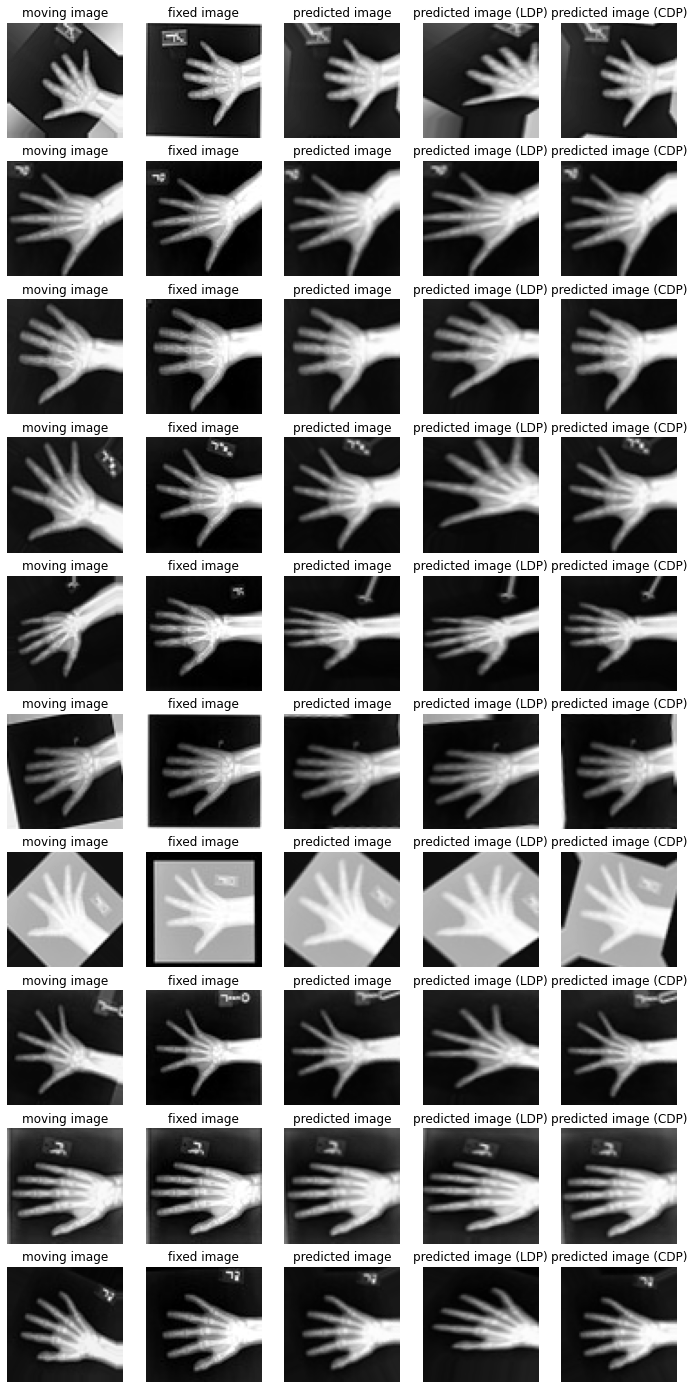

2022-05-30 11:56:07,493 fedbiomed INFO - CRITICAL
					 NODE node_2a30feea-de87-4514-8670-17019e35983a
					 MESSAGE: Node stopped in signal_handler, probably by user decision (Ctrl C)
-----------------------------------------------------------------
05/30/2022 11:56:07:INFO:CRITICAL
					 NODE node_2a30feea-de87-4514-8670-17019e35983a
					 MESSAGE: Node stopped in signal_handler, probably by user decision (Ctrl C)
-----------------------------------------------------------------
2022-05-30 11:56:08,703 fedbiomed INFO - CRITICAL
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: Node stopped in signal_handler, probably by user decision (Ctrl C)
-----------------------------------------------------------------
05/30/2022 11:56:08:INFO:CRITICAL
					 NODE node_a03a2d7a-2c45-462b-b3df-7063fe41d86c
					 MESSAGE: Node stopped in signal_handler, probably by user decision (Ctrl C)
-----------------------------------------------------------------


In [75]:
%matplotlib inline
batch_size = 10
plt.subplots(batch_size, 5, figsize=(12, 25))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 5, b * 5 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 5, b * 5 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 5, b * 5 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
    # warped moving LDP
    plt.subplot(batch_size, 5, b * 5 + 4)
    plt.axis('off')
    plt.title("predicted image (LDP)")
    plt.imshow(pred_image_LDP[b], cmap="gray")
    # warped moving CDP
    plt.subplot(batch_size, 5, b * 5 + 5)
    plt.axis('off')
    plt.title("predicted image (CDP)")
    plt.imshow(pred_image_CDP[b], cmap="gray")
plt.axis('off')
plt.show()